In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import scipy.misc as misc
import math
import imageio

import itertools

# Operator imports
import ndoperators as ops
import llops as yp

# Libwallerlab imports
from ndoperators.solvers import iterative, objectivefunctions
import libwallerlab.projects.motiondeblur as md
import libwallerlab.algorithms
import libwallerlab.utilities.simulation as sim

In [2]:
ops.setDefaultBackend('numpy') # arrayfire or numpy
ops.setDefaultDatatype('complex32')

global_dtype = yp.config.default_dtype
global_backend = yp.config.default_backend

# Functions for Simple Simulation



In [13]:
def forward_simulation(object_true, measurement_size, horz_shift, sigma, blur_type):
    image_size = object_true.shape
    # forward operators
    W = ops.Crop(image_size, measurement_size, crop_start=(0,0))
    S1 = ops.Shift(image_size, (0,0))
    S2 = ops.Shift(image_size, (0,-horz_shift))
    
    # TODO: add blur
    if blur_type is not None:
        blur_length = int(measurement_size[1]*0.2)
        if blur_type == 'constant':
            illum = yp.ones(blur_length)
        elif blur_type == 'pseudorand':
            illum, _ = md.blurkernel.genRandInitialization(blur_length, 0.5)
        elif blur_type == 'random':
            illum = np.random.uniform(size=blur_length)
        blur_kernel, illum = get_centered_horizontal_blur_kernel(illum, 0.5, image_size)
        C = ops.Convolution(blur_kernel, mode='circular')
    else:
        blur_kernel, _ = get_centered_horizontal_blur_kernel(yp.ones(1), 0.5, image_size)
        C = ops.Identity(image_size)
    
    # simulating measurements
    y1 = W * S1 * C * yp.vectorize(yp.astype(object_true)) 
    y2 = W * S2 * C * yp.vectorize(yp.astype(object_true)) 

    # adding noise
    scale1 = np.amax(np.abs(y1)) - np.amin(np.abs(y1))
    scale2 = np.amax(np.abs(y2)) - np.amin(np.abs(y2))

    y1 += sigma * scale1 * np.random.normal(size=measurement_size)
    y2 += sigma * scale2 * np.random.normal(size=measurement_size)

    y_list = [y1,y2]
    return y_list, blur_kernel

def get_centered_horizontal_blur_kernel(illum_vec, throughput, object_size):
    ilum_vec = throughput * illum_vec / np.sum(illum_vec)
    blur_kernel = yp.zeros(object_size)
    mid_y = int(np.round(object_size[0] / 2)); mid_x = (object_size[1] / 2)
    start_x = int(np.round(mid_x - len(illum_vec)/2)) 
    end_x = start_x + len(illum_vec)
    blur_kernel[mid_y, start_x:end_x] = illum_vec
    return blur_kernel, illum_vec 

def registration_results(percent_overlap, sigma, blur_type):
    measurement_size = np.array((128,128))
    
    # Image size to simulate
    image_size = np.array([measurement_size[0], int(measurement_size[1]*(2-percent_overlap))])
    image_load_size = np.array([measurement_size[0], int(measurement_size[1]*(2))])

    # Create test object
    # TODO: weird border issue, this is a hack
    brain = sim.testObject('brain', image_load_size + np.array([2,2]), color_channel=2, dtype=yp.getNativeDatatype(global_dtype, 'numpy'))
    FOV_crop = ops.Crop(image_load_size, image_size, crop_start=(0,0))
    object_true = FOV_crop * yp.astype(yp.changeBackend(brain[1:-1,1:-1], global_backend), global_dtype)

    # Determine crop offset
    if percent_overlap == 1:
        horz_shift = int(0.333 * measurement_size[1])
    else:
        horz_shift = image_size[1]-measurement_size[1]
    print(horz_shift)
   
    # simulating cropped, noisy measurements
    y_list, blur_kernel = forward_simulation(object_true, measurement_size, horz_shift, sigma, blur_type)
    y = np.vstack(y_list)
    
    # register with Phase Correlation
    info_list = md.register_images(y_list, process=False, sigma=0, debug=True)
    info = info_list[0] # we know there is only one pair
    shifts, _, _, cross_correlation = info
    print(percent_overlap, sigma, horz_shift, shifts)
    
    if shifts[1] < 0: # wrapping so shift is always positive
        shifts[1] += measurement_size[1]
        
    # TODO: add iterative registration recovery
    
    # Show object, measurements, recovered shift
    plt.figure(figsize=(9,3))
    ax1 = plt.subplot(2,3,1)
    ax2 = plt.subplot(2,3,4)
    ax3 = plt.subplot(2,3,2)
    ax4 = plt.subplot(2,3,5)
    
    ax5 = plt.subplot(2,3,3)
    ax6 = plt.subplot(2,3,6)
    
    ax1.imshow(np.abs(np.asarray(object_true)), cmap='gray')
    ax1.set_title('Object (x)')
    
    ax2.imshow((np.abs(np.asarray(y))).reshape([2*measurement_size[0], measurement_size[1]]), cmap='gray')
    ax2.set_title('Measurements shift=' + str(horz_shift))
    
    ax3.imshow(np.abs(cross_correlation)); # ax1.colorbar(); 
    ax3.set_title('Cross Correlation: max at ' + str(shifts))
    ax4.plot(np.mean(np.abs(cross_correlation), axis=0));
    ax4.set_title('Avg Horz Cross Corr')
    
    ax5.set_title('iterative: recovered shift X')
    ax6.set_title('power spectrum of blur kernel')
    if blur_type is not None: ax6.plot(yp.abs(yp.Ft(blur_kernel.flatten())))
    
    plt.tight_layout()
    return y_list


In [14]:
overlaps = [1, 0.5, 0.25]
sigmas = [1e-3, 1e-2, 1e-1]
illums = [None, 'constant', 'random', 'pseudorand']

## Varying Overlap/Windowing

## Varying additive noise

64
0.5 0.001 64 [ 0. 64.]


<IPython.core.display.Javascript object>


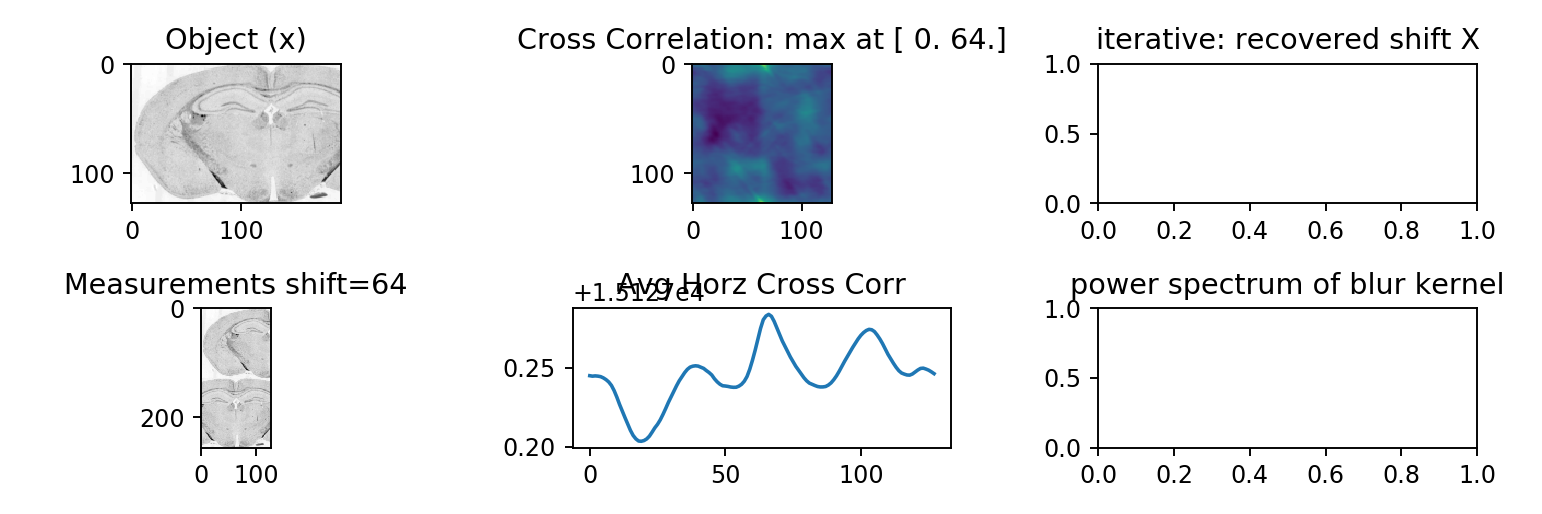

64
0.5 0.01 64 [ 0. 64.]


<IPython.core.display.Javascript object>


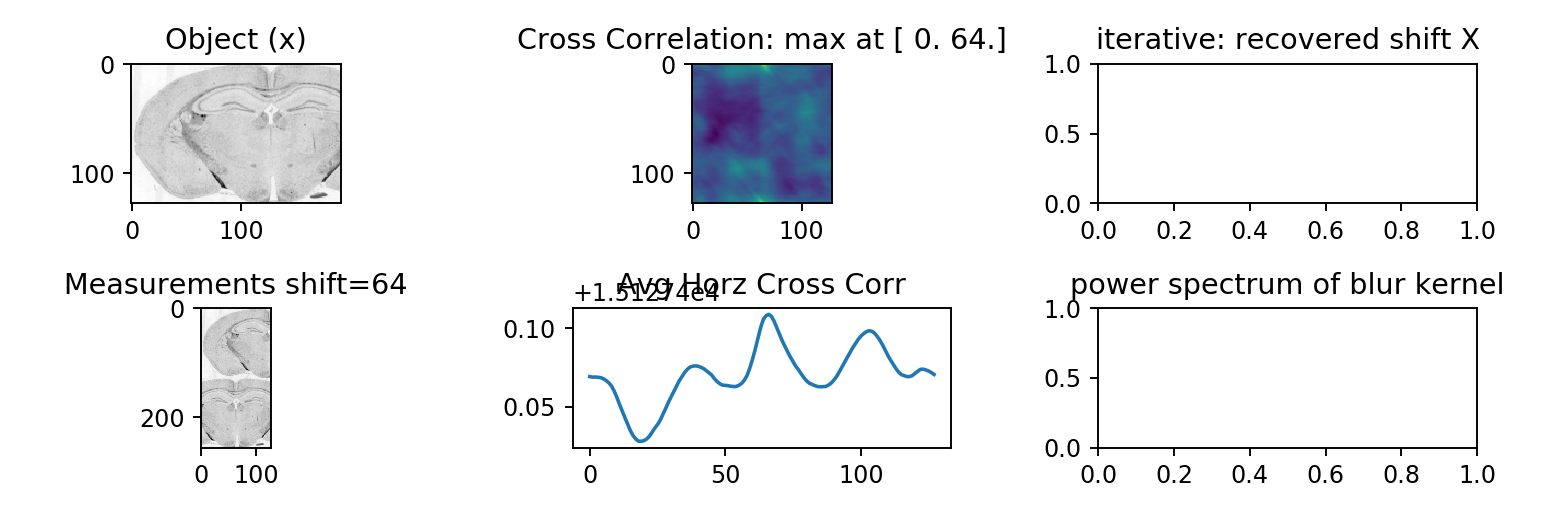

64
0.5 0.1 64 [ 0. 64.]


<IPython.core.display.Javascript object>


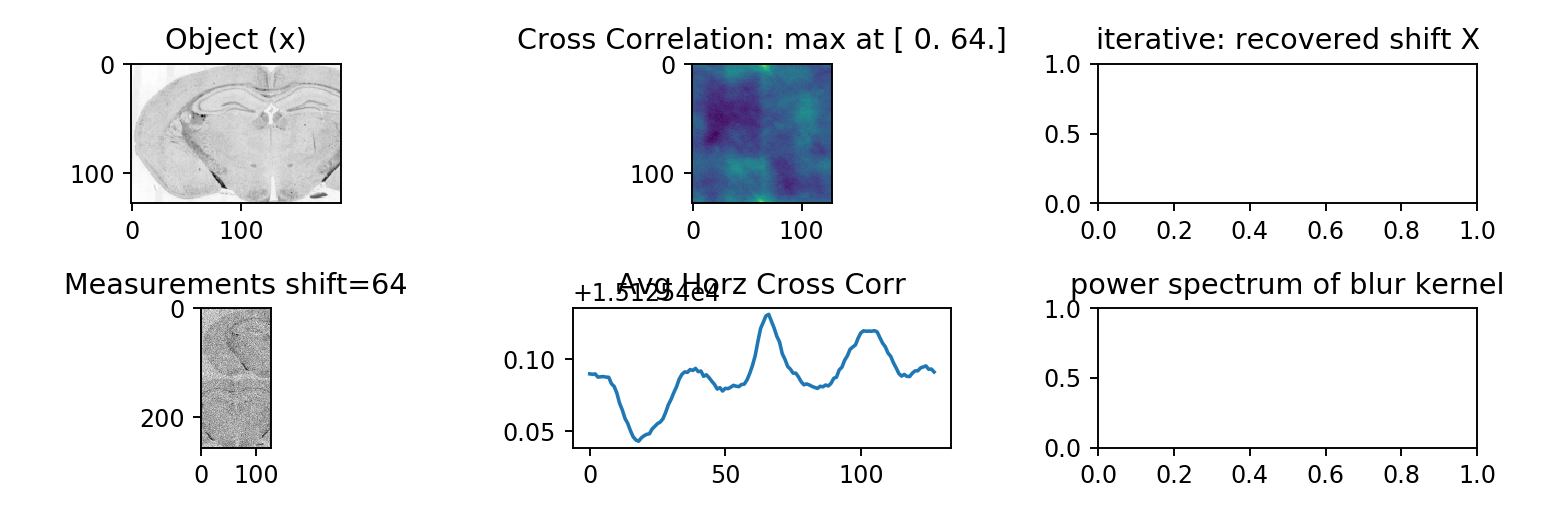

In [6]:
for sigma in sigmas:
    y_list = registration_results(overlaps[1], sigma, None)

## Varying Horizontal Blur

64
0.5 0.01 64 [ 0. 64.]


<IPython.core.display.Javascript object>


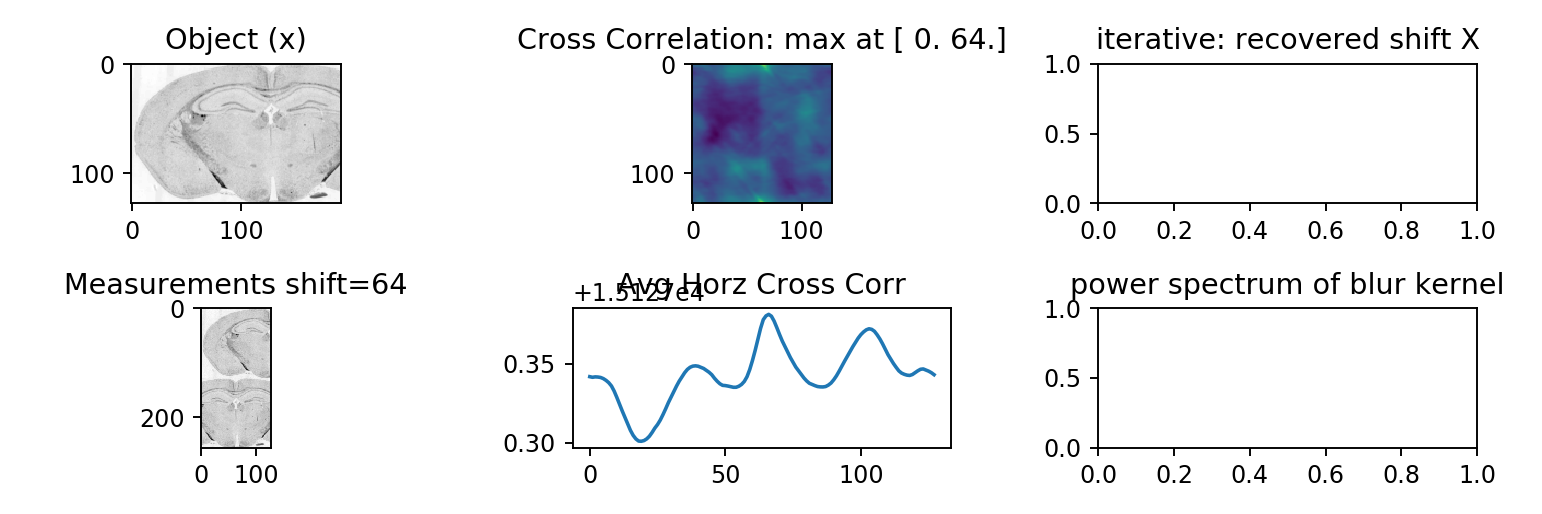

64
0.5 0.01 64 [ 0. 60.]


<IPython.core.display.Javascript object>


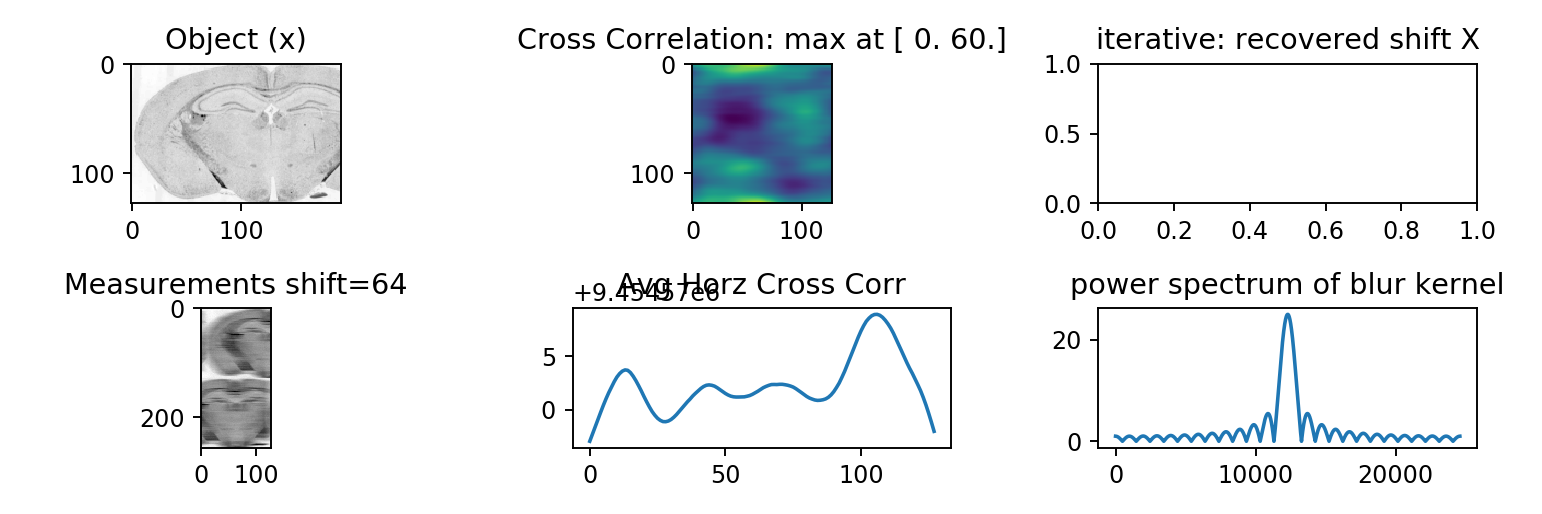

64
0.5 0.01 64 [ 0. 62.]


<IPython.core.display.Javascript object>


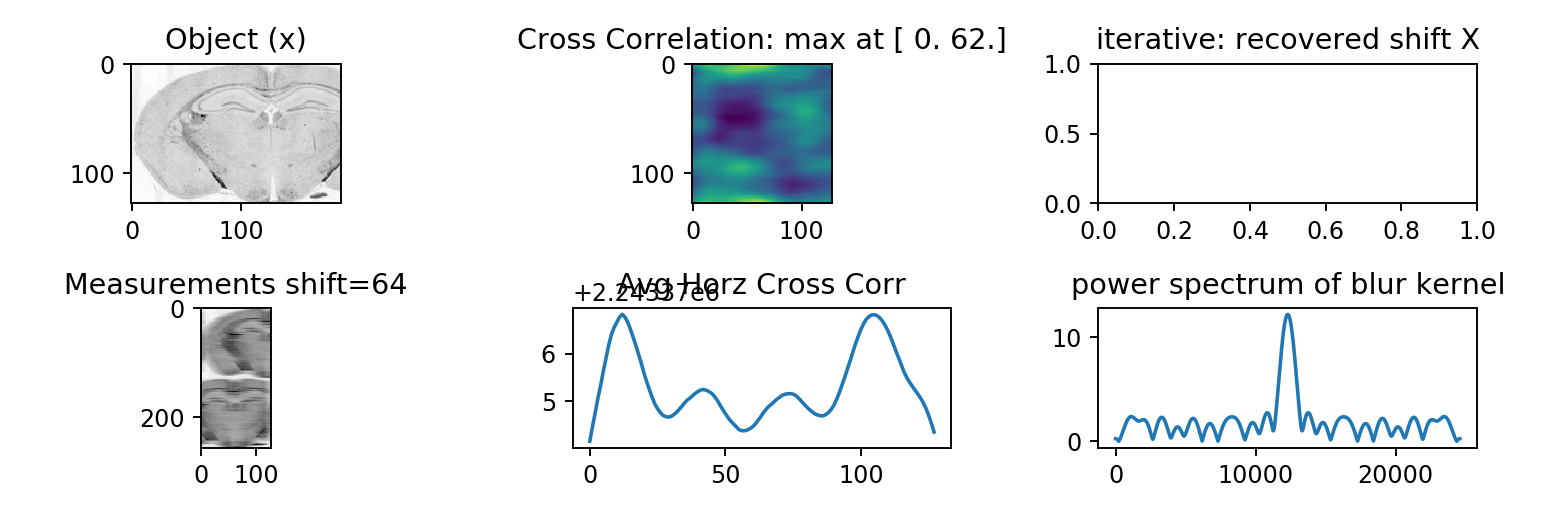

64
0.5 0.01 64 [ 0. 64.]


<IPython.core.display.Javascript object>


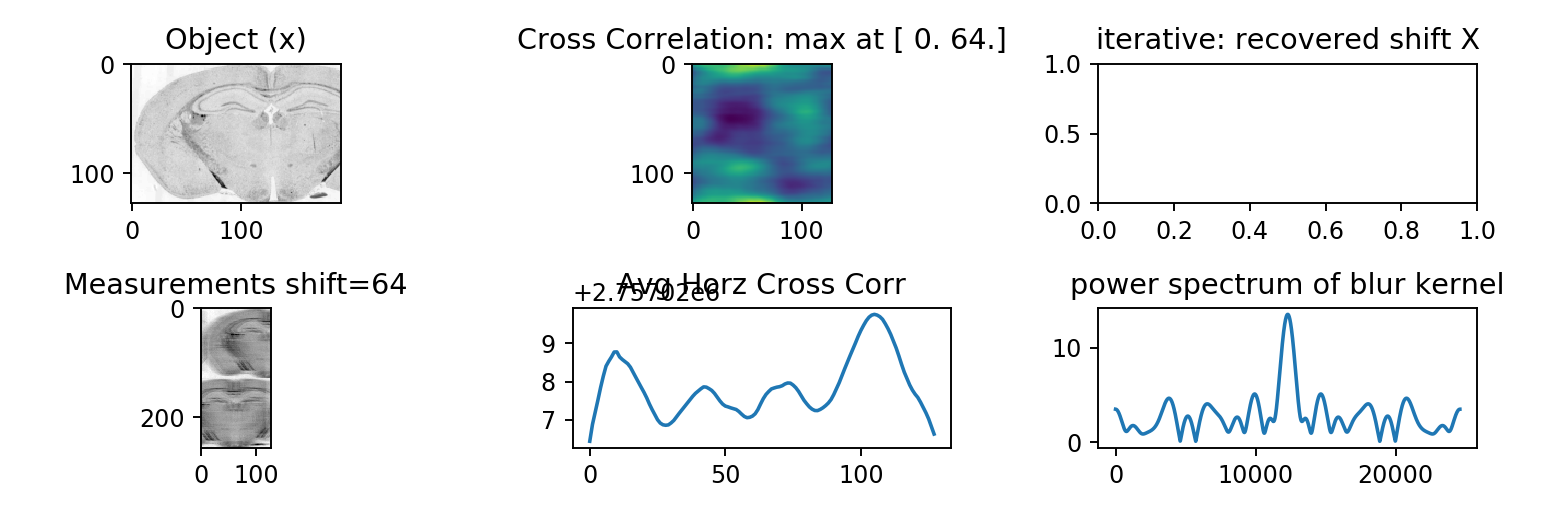

In [11]:
for illum in illums:
    y_list = registration_results(overlaps[1], sigmas[1], illum)

In [16]:
# register with iterative method
y1 = y_list[0]
y2 = y_list[1]

# Create registration object
objective_registration = ops.Registration(y1, y2)
objective_registration.argument = (y1, y2)

# Iterative solution
x_opt = iterative.GradientDescent(objective_registration).solve(iteration_count=100, 
                                  display_type='text', step_size=1.5e-5, display_iteration_delta=50, 
                                  use_nesterov_acceleration=False, nesterov_restart_enabled=True,
                                                               convergence_tol=1e-32)

# Print results
print('Iterative recovered shift: %s' % str(tuple(yp.real(np.asarray(x_opt)))))


/home/sarah/deblurring/libwallerlab/submodules/ndoperators/submodules/llops/llops/base.py:55: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if dtype_str == 'complex32':
/home/sarah/deblurring/libwallerlab/submodules/ndoperators/submodules/llops/llops/base.py:57: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif dtype_str == 'complex64':
/home/sarah/deblurring/libwallerlab/submodules/ndoperators/submodules/llops/llops/base.py:59: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif dtype_str in config.valid_dtypes:
/home/sarah/deblurring/libwallerlab/submodules/ndoperators/ndoperators/operators.py:322: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if getDatatype(x) 

ValueError: Input data type mismatch, for <F: (128, 128)x(128, 128) FourierTransform NUMPY operator with dtype=[[0.97024816+0.j 0.97022426+0.j 0.9699276 +0.j ... 0.9739893 +0.j
  0.9734757 +0.j 0.9734435 +0.j]
 [0.9628462 +0.j 0.958308  +0.j 0.96142745+0.j ... 0.9741731 +0.j
  0.9743295 +0.j 0.9743437 +0.j]
 [0.9597947 +0.j 0.95828784+0.j 0.957842  +0.j ... 0.9724097 +0.j
  0.9734593 +0.j 0.97384703+0.j]
 ...
 [0.97227603+0.j 0.9722972 +0.j 0.97162074+0.j ... 0.9729146 +0.j
  0.9730157 +0.j 0.9735798 +0.j]
 [0.971317  +0.j 0.9703215 +0.j 0.97171366+0.j ... 0.9734615 +0.j
  0.9718795 +0.j 0.972865  +0.j]
 [0.9719914 +0.j 0.97185296+0.j 0.97172695+0.j ... 0.97209466+0.j
  0.9717966 +0.j 0.971137  +0.j]]>, got complex32